In [16]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas
from helper_scripts import random_rm_trace_generator
import importlib
from matplotlib import pyplot as plt
from modules import umap_classifier

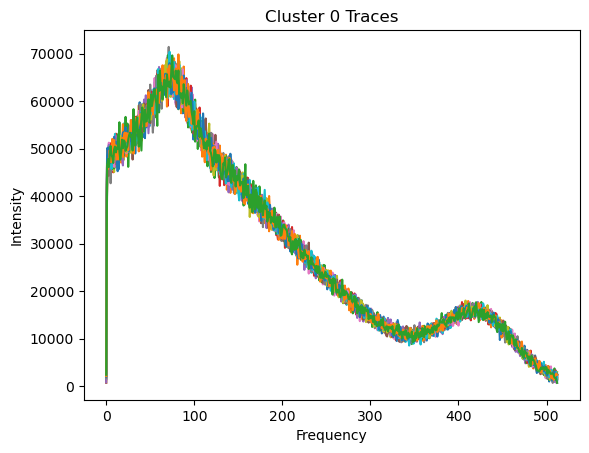

In [17]:
cluster_idx = 0
time_traces, spectra, phase, clusters, _,_=random_rm_trace_generator.generate_random_rm_traces(100, n_clusters=4, outlier_fraction=0.05)
for i in range(100):
    if clusters[i] == cluster_idx:
        plt.plot(spectra[i], label=f'Trace {i+1}')
        plt.xlabel('Frequency')
        plt.ylabel('Intensity')
plt.title(f'Cluster {cluster_idx} Traces')
plt.show()

In [18]:
importlib.reload(umap_classifier)
importlib.reload(random_rm_trace_generator)

<module 'helper_scripts.random_rm_trace_generator' from '/cr/work/kastner/private/umap/rm_classifier/tutorials/notebooks/helper_scripts/random_rm_trace_generator.py'>

In [19]:
u_clas = umap_classifier.UMAPClassifier(yaml_path="../yaml_files/umap_classifier_test.yaml", data_preparation={'target_data_type': "time"})

In [20]:
prepared_data=u_clas.prepare_data(time_traces, input_data_type="time",  data_preparation={'target_data_type': "fft_time"}, 
                 log_filter=False,avg_pooling=None,verbose=False,
                 normalization=True,
                 suppress_dc=True)

No rd_train_std provided. Calculating std from the provided prepared data.
No rd_train_std provided. Calculating std from the provided prepared data.


In [21]:
embeddings=u_clas.embed(prepared_data, save_model="umap_model.pkl")

Embedding data with parameters: n_neighbors=40, min_dist=0.0, n_components=2, metric=braycurtis


/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving UMAP model to umap_model.pkl


/cr/work/kastner/miniconda3/envs/aera01/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


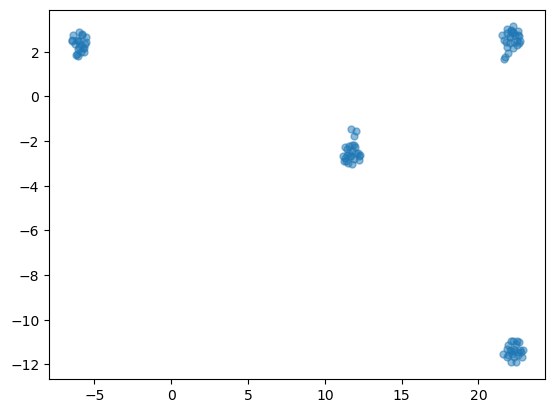

In [24]:
plt.plot(embeddings[:, 0], embeddings[:, 1], 'o', markersize=5, alpha=0.5)